<a href="https://colab.research.google.com/github/DukaPA/ml-product-classification-final/blob/main/notebooks/products_analysis_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza podataka i razvoj modela

Ova sveska vodi kroz sve korake razvoja modela za automatsku klasifikaciju proizvoda po kategorijama. Koristi se skup podataka `products.csv`.

## Učitavanje biblioteka i podataka

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
# Učitavanje podataka

url = "https://raw.githubusercontent.com/DukaPA/ml-product-classification-final/main/data/products.csv"
df = pd.read_csv(url)
print(df.head())

df.info()


   product ID                                      Product Title  Merchant ID  \
0           1                    apple iphone 8 plus 64gb silver            1   
1           2                apple iphone 8 plus 64 gb spacegrau            2   
2           3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...            3   
3           4                apple iphone 8 plus 64gb space grey            4   
4           5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...            5   

   Category Label _Product Code  Number_of_Views  Merchant Rating  \
0   Mobile Phones    QA-2276-XC            860.0              2.5   
1   Mobile Phones    KA-2501-QO           3772.0              4.8   
2   Mobile Phones    FP-8086-IE           3092.0              3.9   
3   Mobile Phones    YI-0086-US            466.0              3.4   
4   Mobile Phones    NZ-3586-WP           4426.0              1.6   

   Listing Date    
0       5/10/2024  
1      12/31/2024  
2      11/10/2024  
3        5/2/2022 

## Osnovna analiza i čišćenje podataka

## Analiza podataka i priprema
Pregledajmo nedostajuće vrijednosti, distribuciju kategorija i osnovne statistike.

Nedostajuce vrednosti po kolonama:
product ID           0
Product Title      172
Merchant ID          0
Category Label      44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
Listing Date        59
dtype: int64


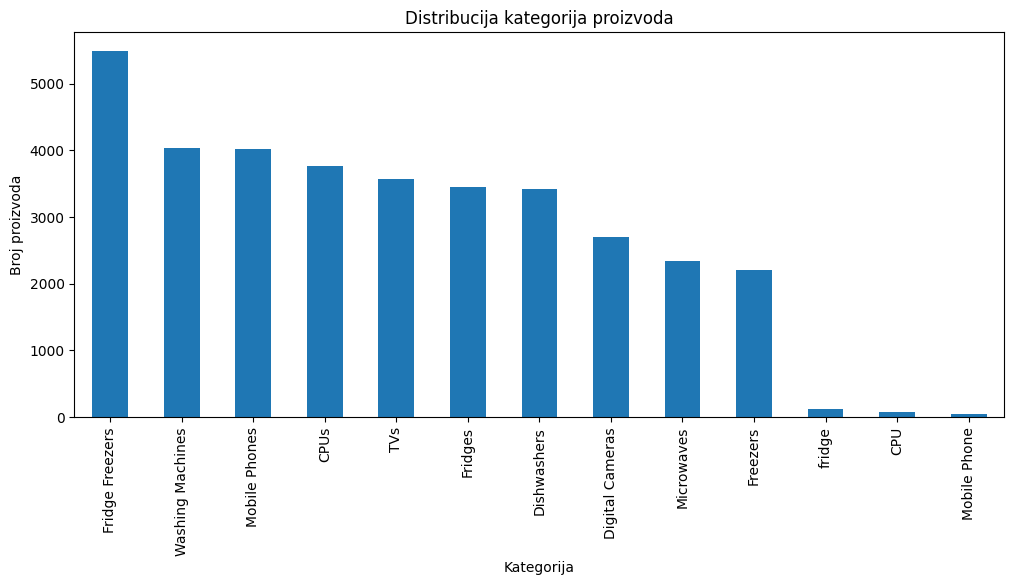

          product ID    Product Title   Merchant ID   Category Label  \
count   35311.000000            35139  35311.000000            35267   
unique           NaN            30860           NaN               13   
top              NaN  washing machine           NaN  Fridge Freezers   
freq             NaN               90           NaN             5495   
mean    26150.800176              NaN    120.501883              NaN   
std     13498.191220              NaN    117.045557              NaN   
min         1.000000              NaN      1.000000              NaN   
25%     14958.500000              NaN     17.000000              NaN   
50%     27614.000000              NaN     75.000000              NaN   
75%     37508.500000              NaN    253.000000              NaN   
max     47358.000000              NaN    371.000000              NaN   

       _Product Code  Number_of_Views  Merchant Rating Listing Date  
count          35216     35297.000000     35141.000000        352

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Provera i čišćenje imena kolona
df.columns = df.columns.str.strip()
# Provera nedostajućih vrednosti
print('Nedostajuce vrednosti po kolonama:')
print(df.isnull().sum())

# Distribucija kategorija
plt.figure(figsize=(12,5))
df['Category Label'].value_counts().plot(kind='bar')
plt.title('Distribucija kategorija proizvoda')
plt.xlabel('Kategorija')
plt.ylabel('Broj proizvoda')
plt.show()

# Osnovne statistike
print(df.describe(include='all'))

## Inženjering karakteristika
Dodajemo nove karakteristike koje mogu pomoći modelu: broj reči, prisustvo brojeva, dužina najduže reči, prisustvo brenda itd.

In [24]:
# Dodavanje novih karakteristika
df['broj_reci'] = df['Product Title'].apply(lambda x: len(str(x).split()))
df['ima_broj'] = df['Product Title'].apply(lambda x: any(char.isdigit() for char in str(x)))
df['duzina_najduze_reci'] = df['Product Title'].apply(lambda x: max([len(word) for word in str(x).split()]) if isinstance(x, str) else 0)
df['ima_brend'] = df['Product Title'].str.contains('Samsung|Apple|Bosch|Smeg|Kenwood|Olympus', case=False, regex=True)

## Treniranje modela
Koristimo TF-IDF vektorizaciju naslova i dodane karakteristike za treniranje modela.

In [25]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

# Očisti NaN vriednosti u 'Product Title' i 'Category Label'
df['Product Title'] = df['Product Title'].fillna('')
df = df.dropna(subset=['Category Label'])  #  kolona obavezna

# Zamieni NaN u numeričkim karakteristikama s 0 (ili median)
for col in ['broj_reci', 'ima_broj', 'duzina_najduze_reci', 'ima_brend']:
    df[col] = df[col].fillna(0)

# TF-IDF vektorizacija naslova
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df['Product Title'].astype(str))

# Dodatne karakteristike
X_features = df[['broj_reci', 'ima_broj', 'duzina_najduze_reci', 'ima_brend']].astype(float)
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Kombinacija tekstualnih i numeričkih karakteristika
from scipy.sparse import csr_matrix
X_all = hstack([X_text, csr_matrix(X_features_scaled)])

y = df['Category Label']

# Podjela na trening i test
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

# Treniranje modela
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

## Evaluacija modela
Prikazujemo tačnost, klasifikacijski izveštaj i matricu zabune.

Tačnost: 0.9366316983271903
Klasifikacijski izvestaj:
                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        17
            CPUs       0.98      0.99      0.98       754
 Digital Cameras       0.99      0.99      0.99       539
     Dishwashers       0.91      0.94      0.92       684
        Freezers       0.98      0.86      0.91       442
 Fridge Freezers       0.91      0.92      0.92      1099
         Fridges       0.86      0.86      0.86       691
      Microwaves       0.98      0.94      0.96       468
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.93      0.99      0.96       804
             TVs       0.96      0.98      0.97       713
Washing Machines       0.93      0.94      0.94       807
          fridge       0.00      0.00      0.00        25

        accuracy                           0.94      7054
       macro avg       0.73      0.72      0.72      7054
    weighted avg

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


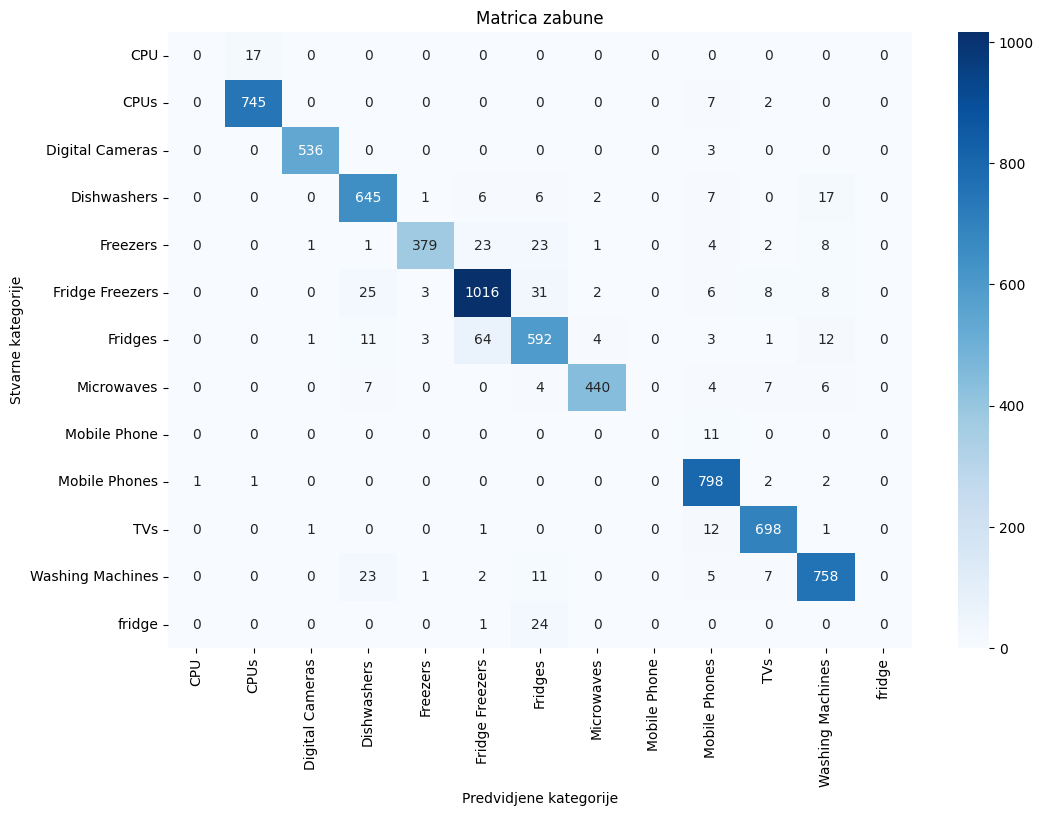

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Predikcija na test skupu
y_pred = model.predict(X_test)

# Tačnost
print('Tačnost:', accuracy_score(y_test, y_pred))

# Klasifikacijski izvještaj
print('Klasifikacijski izvestaj:')
print(classification_report(y_test, y_pred))

# Matrica zabune
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predvidjene kategorije')
plt.ylabel('Stvarne kategorije')
plt.title('Matrica zabune')
plt.show()